In [1]:
push!(LOAD_PATH, pwd())
using LightGraphs, IndirectRec, GraphConnectivityTheory,GraphCreation
using PyCall, PyPlot, Distributions
using CliquePercolation

## $P_{known}$ for gossip percolation among friends.

We consider a special model of gossip where we allow paths of transmission of arbitrary length, with the restriction that every node on the path must be connected to the node about which gossip is spread.
This captures the intuition that gossip is only "fun" when both parties know the subject of the gossip.

We model the clique of $k$ friends as an Erdos-Renyi random graph with $k$ nodes and edge probability $c$ (the local clustering coefficient). The ego node is connected to every one of the nodes of the Erdos Renyi graph.

After applying gossip, the connection probability among friends reduces to $p c$ and the connection probability from ego to a given friend becomes $p$.

We are interested in the probability $P$ that ego will be connected to a given friend. Following the derivation of the random graph reliability function, we develop the following terms:

$$1 - P = \sum_{j = 1}^{k} A_{j}(p c) \binom{k}{j} (1 - p c)^{j (k - j)} \frac{j}{k} (1 - p)^{j}$$

where $A_n(x)$ is the reliability function (probability of being fully connected) of a complete graph of $n$ nodes with edge reliability $x$.


The derivation of this expression is as follows. Consider a specific node $1$ from the friend clique.
Each term on the right hand side is the probability that node $1$ is part of a connected component of size exactly $j$, and that the ego node is _not_ connected to that component.
This is the probability of having such a connected component $A_j(p c)$.
We must factor in the multiplicity $\binom{k}{j}$ of picking the nodes in the connected component.
Further, with probability $\frac{j}{k}$, node $1$ will be part of that component.
Every of the $j$ nodes in the component must be disconnected from the $k-j$ nodes outside of the component.
Finally, the ego node must be disconnected from all $j$ nodes in the component. 

Thus we have enumerated all possibilities where the ego node is _not_ connected to node $1$. The remaining probability must be the probability that they _are_ connected. This reasoning is similar to Gilbert (1959, Random Graphs)

In [2]:
N = 20
change = true
p_range = 0.0:0.025:1.0
c = 0.1
P_range = similar(p_range)
if change
    P_clique_range = similar(p_range)*0
end
P_th_clique_range = similar(p_range)*0
P_th_range = similar(p_range)
num_trials = 50
num_trials_clique = 40


40

In [3]:
#Generate data to compare
for (i,p) in enumerate(p_range)
#      P_range[i] = get_p_known_percolation(g,p,N,num_trials)[end]
#     P_th_range[i] = convert(Float64,get_p_known_percolation_theory(N,1,p))
    P_range[i] = convert(Float64,get_p_known_percolation_theory(N+1,1,p))
    P_th_range[i] = convert(Float64,get_p_known_percolation_theory(N+1,1,p*c))
#     P_th_clique_range[i] = get_p_known_clique_t(N,c,p)# convert(Float64,get_p_known_percolation_theory(N+1,1,p))
    P_th_clique_range[i] = get_p_known_clique_theory(N,c,p)# convert(Float64,get_p_known_percolation_theory(N+1,1,p))
#     P_th_clique_range[i] = get_p_known_clique_theory_approx(N,c,p)# convert(Float64,get_p_known_percolation_theory(N+1,1,p))

    if change
        for j = 1:num_trials_clique
            h = produce_clique_graph(N,c)
            P_clique_range[i] += get_p_known_percolation(h,p,N,num_trials)[1][end] 
        end
        P_clique_range[i] /= num_trials_clique
    end

end

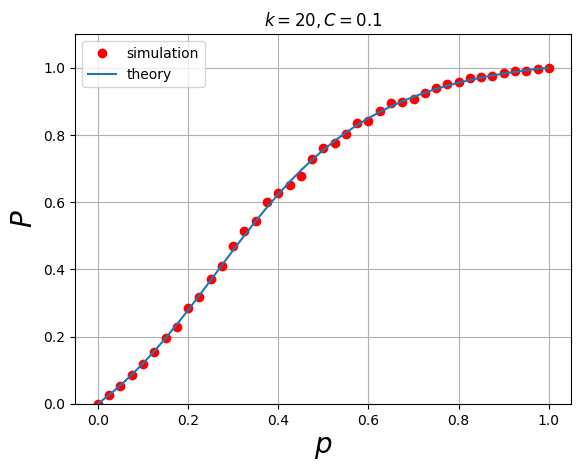

PyObject <matplotlib.legend.Legend object at 0x32a159090>

In [4]:
# plot(p_range,P_range,"--b",label=L"P_{N+1}^{p}")
# plot(p_range,P_th_range,label=L"P_{N+1}^{p c}")
plot(p_range,P_clique_range,"or",label="simulation")
plot(p_range,P_th_clique_range,label="theory")
# f(x) = 1 - (1 - x).^(N/2)
# plot(p_range,f(p_range)./f(c*p_range), label=L"\frac{p(1-p)}{p c (1 - p c)}")
grid()
ylim([0,1.1])
xlabel(L"p",size=20)
ylabel(L"P",size=20)
title(latexstring("\$ k = $N, C = $c \$" ))
legend(loc = "best")

## Approximations to the reliability function

In [212]:
n = 50
p = 0.8
Ans = GraphConnectivityTheory.memoize_An(BigInt(n),BigFloat(p));

function get_An_approx(n,p)
    return 1 - n.*(1-p).^(n-1)
end

get_An_approx (generic function with 1 method)

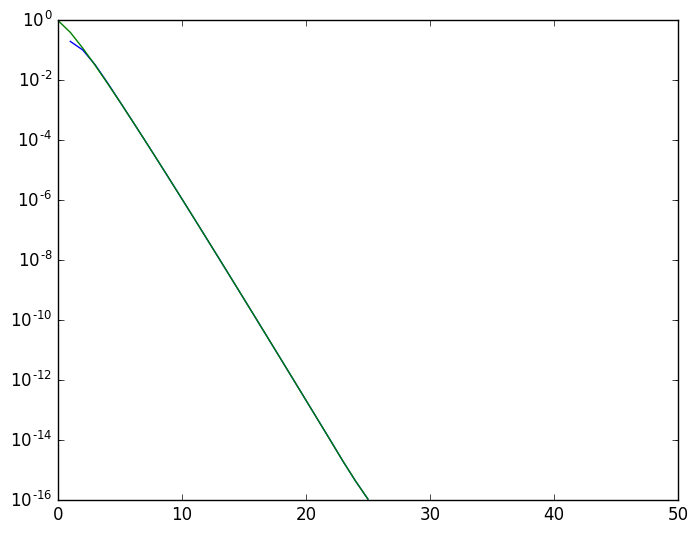

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x330929fd0>

In [213]:
n_range = collect(1:n)
semilogy(1-[convert(Float64,_) for _ in Ans])
semilogy(1-get_An_approx(n_range,p))

In [ ]:
using GraphCreation

graph_type = :fb #:watts_strogatz #:erdos_renyi
N = 200
k = 30
C = 0.4
p = 0.2
@time g = GraphCreation.create_graph(N,k,graph_type,C)


ks = [20,30,20]#,20,40,60
num_to_plots = [30,30,100]
Ns = [200,200,200,200]
colors = ["r","c","k"]
graph_names = ["watts strogatz","erdos renyi", "facebook"]
types = [:watts_strogatz,:erdos_renyi,:fb]
gs = [GraphCreation.create_graph(N,ks[i],types[i],C) for i in 1:length(types)]
P_arr = []
Pth_arr = []
cs_arr = []
ks_arr = []
ns_arr = []

trials = 400

# gs = [g]
# g = erdos_renyi(100,0.1)

for (i,g) in enumerate(gs)#[0.2,0.2,0.2]#[0.1,0.2,0.3,0.4,0.5]
    P,P_th,cs,ks = generate_p_knowns_theory_simulation(g,p,trials)
#     P,cs,ks = generate_p_knowns_simulation(g,p,trials)
    push!(P_arr,P)
    push!(Pth_arr,P_th)
    push!(cs_arr,cs)
    push!(ks_arr,ks)
    push!(ns_arr,(ks-1).*cs)
end


  0.095083 seconds (1.32 M allocations: 46.096 MB, 15.50% gc time)
  3.764682 seconds (25.23 M allocations: 2.113 GB, 10.49% gc time)
  0.176635 seconds (1.83 M allocations: 52.792 MB, 28.95% gc time)
  5.212768 seconds (32.99 M allocations: 2.756 GB, 7.78% gc time)


In [ ]:

num_to_plots = [40,40,200]
alphas = [0.9,0.7,0.3]
for (i,g) in enumerate(gs)
#     P,P_th,cs,ks = generate_p_knowns_theory_simulation(g,p)

    P = P_arr[i]
    
    P_err = (P.*(1-P)./trials).^0.5
    P_th = Pth_arr[i]
    ns = ns_arr[i]
    
#     theory_vs_simulation_p_knowns_single_param(P,P_th,cs,ks,p)
    
    println(graph_names[i])
    println(mean(ks_arr[i]))
    println(mean(cs_arr[i]))
    indices = sample(1:length(P),num_to_plots[i],replace=false)
#     scatter(ns[indices],P[indices],color=colors[i],s=1,alpha=0.8,label=graph_names[i])
    figure(1)
    theory_vs_simulation_p_knowns(P[indices],P_th[indices],P_err[indices],colors[i])
    figure(0)
    label_str = latexstring("$(graph_names[i]), \$N = $(nv(g))\$, \$k = $(@sprintf("%.2f",mean(ks)))\$, \$C = $(@sprintf("%.2f",mean(cs)))\$")
    errorbar(ns[indices],P[indices],yerr=P_err[indices],color=colors[i],linestyle="none",capsize=4,linewidth=1,label=label_str,alpha=alphas[i])#,s=1,alpha=0.8,)

    
#     plot(c_grid[:].*(k_grid[:]-1),p_knowns_range[:],"o")
end
plot_p_known_theory_vs_n(p,50)

# title_str = latexstring("Facebook Graph, \$p = $p\$, \$N = $(nv(g))\$, \$k = $(@sprintf("%.2f",mean(ks)))\$, \$C = $(@sprintf("%.2f",mean(cs)))\$")
# title(title_str)
xlim([0,50])
ylim([0,1.1])
xlabel(L"n = (k-1)c",size=20)
ylabel(L"P",size=20)
legend(loc="lower right")

In [212]:
function generate_p_knowns_theory_simulation(g,p,trials=100)
    ks = degree(g)
    cs = local_clustering_coefficient(g)
    IndirectRec.get_singleton_nodes_array(g)
    @time p_knowns,_ = get_p_known_clique_percolation(g,p,trials)
    p_knowns_th = zeros(nv(g))
    @time for v in 1:nv(g)
        p_knowns_th[v] = get_p_known_clique_theory(ks[v],cs[v],p) 
    end
    p_knowns,p_knowns_th,cs,ks
end

function generate_p_knowns_simulation(g,p,trials=100)
    ks = degree(g)
    cs = local_clustering_coefficient(g)
    IndirectRec.get_singleton_nodes_array(g)
    @time p_knowns,_ = get_p_known_clique_percolation(g,p,trials)
    p_knowns,cs,ks
end

    

function theory_vs_simulation_p_knowns(p_knowns,p_knowns_th,p_knowns_error=nothing,color="b")
    # scatter(1:nv(g),p_knowns,color="r")
    if p_knowns_error==nothing
        scatter(p_knowns_th,p_knowns,alpha=0.2,color=color)
    else
        errorbar(p_knowns_th,p_knowns,yerr=p_knowns_error,color=color,linestyle="none",capsize=4,linewidth=1,alpha=0.7)#,s=1,alpha=0.8,)
    end
    xx = 0:0.1:1
    plot(xx,xx,"--k")
    xlim([0,1])
    ylim([0,1])
    xlabel(L"$P$ [Theory]",size=20)
    ylabel(L"$P$ [Simulation]",size=20)
#     title_str = latexstring("Erdos Renyi, \$p = $p\$, \$N = $(nv(g))\$, \$k = $(@sprintf("%.2f",mean(ks)))\$, \$C = $(@sprintf("%.2f",mean(cs)))\$")
#     title(title_str,size=15)
end

# scatter(cs_fb.*(ks_fb-1),p_knowns_th_fb,color="b",alpha=0.05,label="theory")
# scatter(cs_fb.*(ks_fb-1),p_knowns_fb,color="r",alpha=0.05,label="observation")
function theory_vs_simulation_p_knowns_single_param(p_knowns,p_knowns_th,cs,ks,cs_th,ks_th,p)
    scatter(cs_th.*(ks_th-1),p_knowns_th,color="b",alpha=0.05)
    scatter(cs.*(ks-1),p_knowns,color="r",alpha=0.05)

    title_str = latexstring("Facebook Graph, \$p = $p\$, \$N = $(nv(g))\$, \$k = $(@sprintf("%.2f",mean(ks)))\$, \$C = $(@sprintf("%.2f",mean(cs)))\$")
    title(title_str)
    xlim([0,maximum(cs.*ks)+1])
    xlabel(L"n = (k-1)c p",size=20)
    ylabel(L"P",size=20)
    legend(loc="lower right")
end

function plot_p_known_theory_vs_n(p,n_max=50)
    k_max = max(100,2*n_max)
    n_range = 0:1:n_max
    k_range1 = Int64[el for el in ceil(n_range + 1)]
    k_range2 = k_max*ones(k_range1)
    c_range1 = n_range ./ (k_range1-1)
    c_range2 = n_range ./ (k_range2-1)
    @time y1 = Float64[get_p_known_clique_theory(k_range1[i],c_range1[i],p) for i in 1:length(c_range1)];
    @time y2 = Float64[get_p_known_clique_theory(k_range2[i],c_range2[i],p) for i in 1:length(c_range1)];

    pygui(false)
    plt[:fill_between](n_range,y1,y2,alpha=0.4,color="b",label=L"theory $p = 0.2$")
    plot(n_range,y1,"-b",alpha=0.4)
    plot(n_range,y2,"-b",alpha=0.4)
    # plot(c_grid[:].*(k_grid[:]-1),p_knowns_range[:],"o")
    # plot(x1,y1,"-")
    xlabel(L"n = (k-1)c",size=20)
    ylabel(L"P",size=20)
    legend(loc="center right")
    xlim([0,n_max])
end


plot_p_known_theory_vs_n (generic function with 2 methods)

In [5]:
# p_knowns_fb = p_knowns
# p_knowns_th_fb = p_knowns_th
nv(g),mean(cs),mean(ks)

LoadError: UndefVarError: cs not defined

For the Watts Strogatz model this theory works least well because the "randomness assumption" of which neighbor is connected to whom is least true. We have a group of local neighbors that are all connected. We have a group of global neighbors that are almost surely not connected to any other neighbors.

## Exploring the theoretical predictions.

In [2]:
p = 0.2
k_range = [1,4,16,64,128]#collect(1:5:150)
c_range = collect(0.01:0.05:1)
k_grid = repmat(k_range,1,length(c_range))
c_grid = repmat(c_range',length(k_range),1)
p_knowns_range = zeros(length(k_range),length(c_range))

@time for i in 1:length(k_range)
    for j in 1:length(c_range)
        p_knowns_range[i,j] = get_p_known_clique_theory(k_range[i],c_range[j],p) 
    end
end


  0.982862 seconds (8.85 M allocations: 254.095 MB, 22.80% gc time)


In [16]:
plt[:rc]("text",usetex=true)

plot_p_known_theory_vs_n (generic function with 2 methods)

  0.099389 seconds (992.80 k allocations: 28.627 MB, 23.16% gc time)


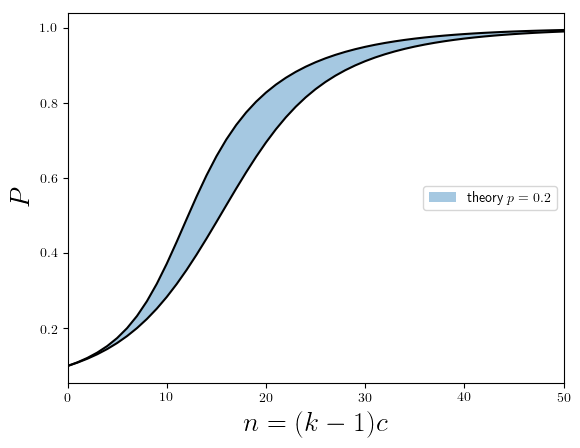

  1.210862 seconds (10.84 M allocations: 310.940 MB, 27.76% gc time)


(0,50)

In [87]:
plot_p_known_theory_vs_n(0.1,50)

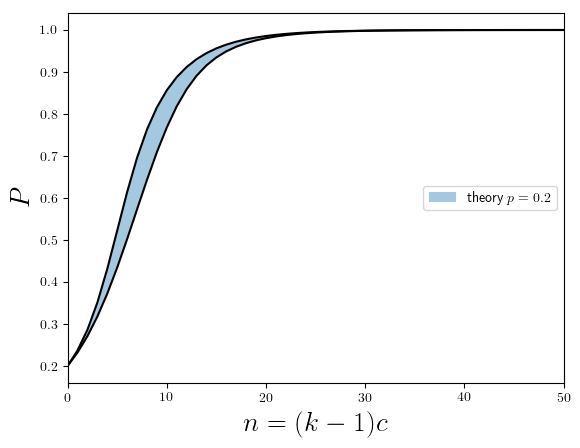

(0,50)

In [74]:
close("all")
pygui(false)
figure()
plt[:fill_between](n_range,y1,y2,alpha=0.4,label=L"theory $p = 0.2$")
plot(n_range,y1,"-k")
plot(n_range,y2,"-k")
# plot(c_grid[:].*(k_grid[:]-1),p_knowns_range[:],"o")
# plot(x1,y1,"-")
xlabel(L"n = (k-1)c",size=20)
ylabel(L"P",size=20)
legend(loc="center right")
xlim([0,50])

In [8]:
L"a + b^2"

L"$a + b^2$"

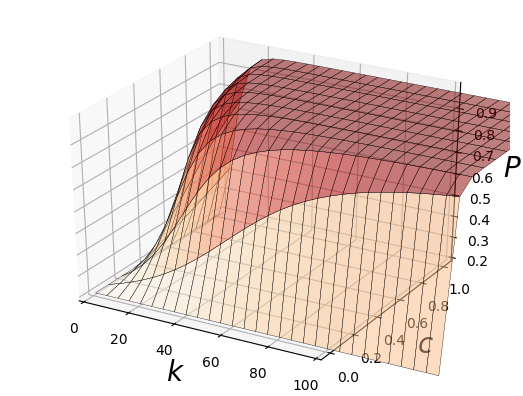

(0,100)

In [69]:
close("all")
ax = figure()[:add_subplot](1,1,1, projection="3d")
#ax[:scatter3D](ks_fb,cs_fb,p_knowns_fb,alpha=0.5)
ax[:plot_surface](k_grid,c_grid, p_knowns_range, edgecolors="k",cstride=1,rstride=1, 
cmap=ColorMap("OrRd"), alpha=.5, linewidth=0.25)
xlabel(L"k",size=20)
ylabel(L"c",size=20)
zlabel(L"P",size=20)
xlim([0,100])
# pygui(true)
# ion()

# Neighbor to neighbor percolation

We wish to evaluate the cost of defecting with a _given_ neighbor. Assume any neighbor will propagate information about our behavior with probability $p$ across every edge. Then let $P^{neighbor}_{known}$ be the probability that this information reaches a given other neighbor of mine. For each such neighbor they will not cooperate with me which incurs a cost $b$. The total cost of defection is thus
$$(k - 1) P^{neighbor}_{known} b$$
while I save a cost $c$. Thus, defecting on a given neighbor makes sense if
$$P^{neighbor}_{known} < \frac{c}{(k-1)b}$$

We then assume that each edge is broken if one of the members of that edge defects. We thus update the graph at every time step. We then add a random set of edges to make up for the lost edges. Repeat this process and observe how the graph changes. We can do this as a function of the $b/c$ ratio on the graph.

By assuming that all my neighbors are connected like a random graph, 
$P^{neighbor}_{known}$ can be approximated as the two terminal reliability function on a graph of size $k$ and with edge existence probability $c p$, where $k$ is the local degree and $c$ is the local clustering coefficient.

In [17]:
graph_type = :erdos_renyi
N = 100
k = 50
C = 0.2
g = GraphCreation.create_graph(N,k,graph_type,C)
neighbors(g,1)

47-element Array{Int64,1}:
   2
   6
   7
  16
  21
  22
  23
  24
  25
  26
  27
  28
  29
   ⋮
  76
  80
  83
  87
  88
  89
  91
  94
  96
  97
  98
 100

In [134]:
function remove_edges_according_to_reputation(g,p,b_c_ratio,num_trials= 10)
    h = copy(g)
    num_edges = ne(h) 
    
    for v in vertices(g)
        ns = neighbors(g,v)
        k = length(ns)
        for w in ns 
            P_neighbor_known = get_p_known_from_neighbor_to_other_neighbor(g,p,v,w,num_trials)
            if P_neighbor_known < 1/(b_c_ratio*(k-1))
                rem_edge!(h,Pair(v,w))
            end
        end
    end
    
    num_edges_after = ne(h)
    num_edges_removed = num_edges - num_edges_after
    println("before: $(num_edges), after: $(num_edges_after), removed: $(num_edges_removed)" )
    return h,num_edges_removed
end

function add_random_edges(g,num_edges)
    added = 0
    vs = vertices(g)
    while added < num_edges
        v1 = rand(vs)
        v2 = rand(vs)
        e = Pair(v1,v2)
        if valid_edge(g,e)
            add_edge!(g,e)
            added += 1
        end
    end
end

function valid_edge(g,e)
    if e[1] == e[2] return false end
    if has_edge(g,e) return false end
    return true
end
    
    
function get_cs_ks_ns(g)            
    cs = local_clustering_coefficient(g)
    ks = degree(g)
    ns = cs.*(ks-1)
    return cs,ks,ns
end
    

get_cs_ks_ns (generic function with 1 method)

### Run the dynamic graph model
We remove edges if at least one of the nodes defects. Add random edges to compensate for the lost edges and repeat. The resulting graph becomes more and more like a social network!

The clustering, embeddedness, and variance of the degree distribution tend to rise every time step! This is at the cost of producing several singleton nodes.

There also seems to be a notion of "convergence", where the number of repalced edges decreases over time and the graph becomes stable in the cooperation sense.

In [287]:
N = 400
k = 10
g = GraphCreation.create_graph(N,k,:erdos_renyi,C)
g_orig = copy(g)

p = 0.5
b_c_ratio = 2
num_trials = 100
num_iters = 20

c_m = zeros(num_iters+1)
n_m = zeros(num_iters+1)
k_std = zeros(num_iters+1)

cs,ks,ns = get_cs_ks_ns(g)
ks_orig = ks
cs_orig = cs
ns_orig = ns
c_m[1] = mean(cs)
n_m[1] = mean(ns)
k_std[1] = std(ks)


for i = 1:num_iters
    g,num_removed = remove_edges_according_to_reputation(g,p,b_c_ratio,num_trials)
    add_random_edges(g,num_removed)
    cs,ks,ns = get_cs_ks_ns(g)
    c_m[1+i] = mean(cs)
    n_m[1+i] = mean(ns)
    k_std[1+i] = std(ks)
end

ks_end = ks
cs_end = cs
ns_end = ns

before: 2081, after: 228, removed: 1853
before: 2081, after: 291, removed: 1790
before: 2081, after: 365, removed: 1716
before: 2081, after: 432, removed: 1649
before: 2081, after: 475, removed: 1606
before: 2081, after: 596, removed: 1485
before: 2081, after: 653, removed: 1428
before: 2081, after: 759, removed: 1322
before: 2081, after: 829, removed: 1252
before: 2081, after: 952, removed: 1129
before: 2081, after: 1041, removed: 1040
before: 2081, after: 1142, removed: 939
before: 2081, after: 1260, removed: 821
before: 2081, after: 1395, removed: 686
before: 2081, after: 1477, removed: 604
before: 2081, after: 1568, removed: 513
before: 2081, after: 1659, removed: 422
before: 2081, after: 1724, removed: 357
before: 2081, after: 1790, removed: 291
before: 2081, after: 1834, removed: 247


400-element Array{Float64,1}:
  3.09091
  1.6    
  0.0    
  2.0    
  2.35294
 -0.0    
  3.52   
  0.0    
  2.53333
  4.06452
  3.27273
  0.0    
  2.0    
  ⋮      
  2.2    
  2.28571
  4.8    
  1.71429
 -0.0    
 -0.0    
  0.0    
  2.0    
 -0.0    
  0.0    
  0.0    
  0.0    

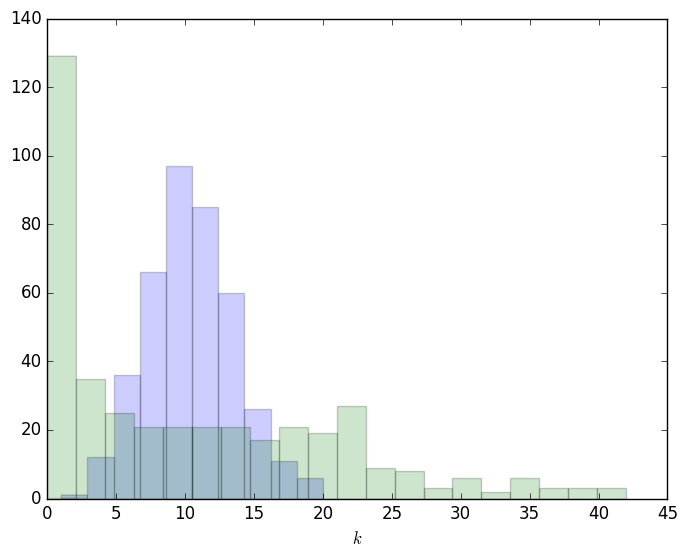

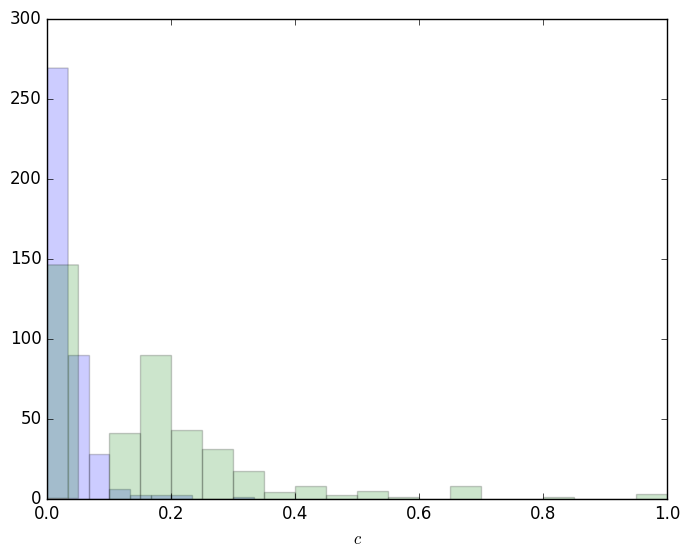

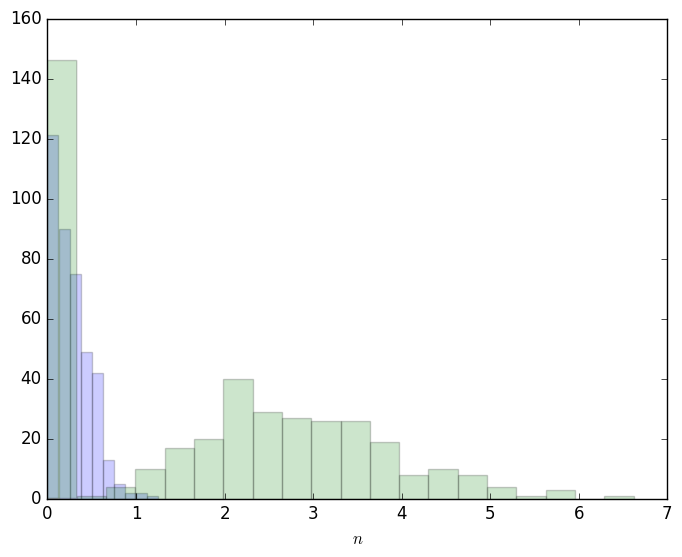

PyObject <matplotlib.text.Text object at 0x32df33b10>

In [298]:
figure()
# bins = logspace(1,log10(maximum(ks_end)),50)
# gca()[:hist](1+ks_orig,bins=bins,log=true,alpha=0.2)
# gca()[:hist](1+ks_end,bins=bins,alpha=0.2)
# gca()[:set_xscale]("log")
gca()[:hist](ks_orig,alpha=0.2)
gca()[:hist](ks_end,bins=20,alpha=0.2)
xlabel(L"k")
figure()
gca()[:hist](cs_orig,alpha=0.2)
gca()[:hist](cs_end,bins=20,alpha=0.2)
xlabel(L"c")
figure()
gca()[:hist](ns_orig,alpha=0.2)
gca()[:hist](ns_end,bins=20,alpha=0.2)
xlabel(L"n")



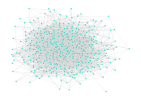

In [299]:
using GraphPlot
gplot(g_orig)

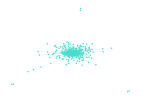

In [300]:
using Colors
h,_ = induced_subgraph(g,vertices(g)[degree(g) .> 0])
# nodesize = (1*mean(degree(g))+degree(g))
# nodefillc = [RGBA(0.2,0.5,0.2,rand()0.3+(degree(g,i))/maximum(degree(g))) for i in 1:nv(g)]
# nodefillc = [RGBA(0.2,0.5,0.2,0.001*rand()+0.3) for i in 1:nv(g)]
# gplot(g,layout=spring_layout,nodefillc=nodefillc,NODESIZE=0.1,nodesize=nodesize)
gplot(h)

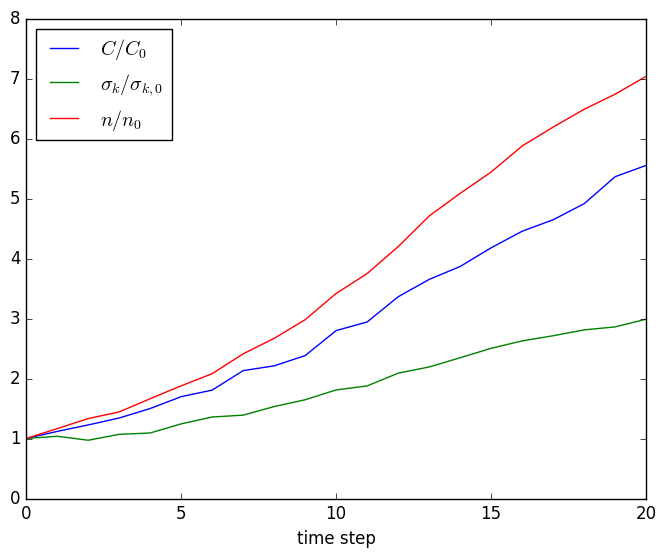

PyObject <matplotlib.legend.Legend object at 0x32e5be810>

In [303]:
plot(c_m/c_m[1],label=L"C/C_0")
plot(k_std/k_std[1],label=L"\sigma_k / \sigma_{k,0}")
plot(n_m/n_m[1],label=L"n/n_0")
xlabel("time step")
legend(loc="best")

# Testing P_known_neighbor

The probability $P_{known}^{neighbor}$ is well approximated by the two terminal reliability function (which is equivalent to the assumption that all the neighbors of a given node are connected among each other like a random graph).

In [49]:
p_range = 0:0.02:0.4
P_range = zeros(p_range)
P_range_theory = zeros(p_range)
p = 0.01
v = 1
w = neighbors(g,v)[1]
for i = 1:length(p_range)
    P_range[i] = get_p_known_from_neighbor_to_other_neighbor(g,p_range[i],v,w,1000)
    c_loc = local_clustering_coefficient(g,v)
    k_loc = degree(g,v)
    P_range_theory[i] = GraphConnectivityTheory.get_Tn_memoized(BigInt(k_loc),BigFloat(c_loc*p_range[i]))
end

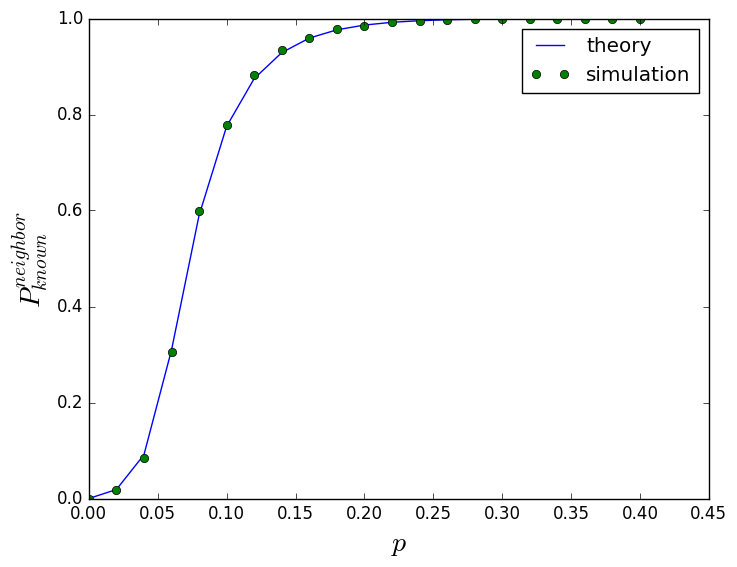

PyObject <matplotlib.legend.Legend object at 0x323e26610>

In [56]:
plot(p_range,P_range_theory,label="theory")
plot(p_range,P_range,"o",label="simulation")
xlabel(L"$p$",size=20)
ylabel(L"$P^{neighbor}_{known}$",size=20)
legend(loc="best")

## TODO what data can we use to test the prediction that cooperation is highly predicted by $n = (k-1) c$.

# MISC

 The probability that it is connected to a given node is
$p + (1 - p)*(1 - (1 - p*p_{perc})^k)$

In [214]:
function get_p_known_clique_t(k::Int,c::Float64,p::Float64)
    N = k 
    p_c = p*c
    p_perc = percolation_erdos_renyi(N+1,p_c)
    p_perc_higher = percolation_erdos_renyi(N+1,p)
    f(x) = (1 - (1 - x)^(N-1))
#     return p + (1-p)*(p_perc - p_c)/((1-p_c)) 
#     return (1-p)*p_perc + p*p_perc_higher
    return p  + (1 - p)/(1 - p_c)*(p_perc - p_c)*f(p)/f(p_c)
end
    
function get_p_known_clique(k::Int,c::Float64,p::Float64)
    N = k 
    p_c = p*c
    p_perc = percolation_erdos_renyi(N+1,p_c)
    return p + (1-p)*p*(p_perc - p_c)/((1-p_c)*p_c) 
end

function prefac(p,c)
    p_c = p*c
    return (1 + p_c - p) / (c)
end

prefac (generic function with 1 method)

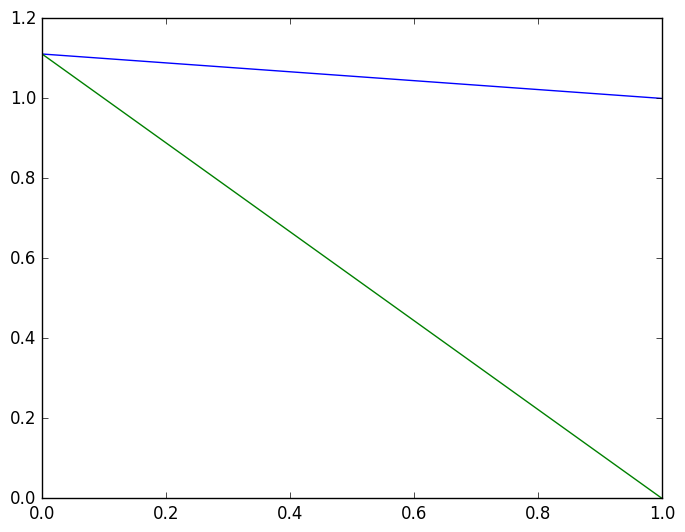

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x3275c65d0>

In [11]:
c = 0.9
pr = 0:0.01:1
plot(pr,prefac(pr,c))
plot(pr,1/c - pr * 1/c)

 The probability that it is connected to a given node is
$p + (1 - p)*(1 - (1 - p*p_{perc})^k)$